In [ ]:
!pip install blackjax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.1/300.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 5.3 MB/s eta 0:00:00


In [121]:
import numpy as np
import jax
from jax import jit, vmap
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp

import blackjax
from blackjax.vi.svgd import SVGDState

import optax

import seaborn as sns
import matplotlib.pyplot as plt

In [122]:
from jax import config
config.update("jax_enable_x64",True)

In [123]:
def gaussian_mixture(x, mu1=-2, mu2=2):
    pdf = lambda x, mu: jax.scipy.stats.norm.pdf(x, loc=mu, scale=1)
    return (1/3)*pdf(x, mu1) + (2/3)*pdf(x, mu2)

def gaussian_mixture_log_pdf(x):
    return jnp.log(gaussian_mixture(x))

In [124]:
def build_kernel(optimizer: optax.GradientTransformation):
    def kernel(
        state: SVGDState,
        grad_logdensity_fn: Callable,
        kernel: Callable,
        **grad_params,
    ) -> SVGDState:
        """
        Performs one step of Stein Variational Gradient Descent.

        See Algorithm 1 of :cite:p:`liu2016stein`.

        Parameters
        ----------
        state
            SVGDState object containing information about previous iteration
        grad_logdensity_fn
            gradient, or an estimate, of the target log density function to samples approximately from
        kernel
            positive semi definite kernel
        **grad_params
            additional parameters for `grad_logdensity_fn` function, for instance a minibatch parameter
            on a gradient estimator.

        Returns
        -------
        SVGDState containing new particles, optimizer state and kernel parameters.
        """
        particles, kernel_params, opt_state = state
        kernel = functools.partial(kernel, **kernel_params)

        def phi_star_summand(particle, particle_):
            gradient = grad_logdensity_fn(particle, **grad_params)
            k, grad_k = jax.value_and_grad(kernel, argnums=0)(particle, particle_)
            return jax.tree_util.tree_map(lambda g, gk: -(k * g) - gk, gradient, grad_k)

        functional_gradient = jax.vmap(
            lambda p_: jax.tree_util.tree_map(
                lambda phi_star: phi_star.mean(axis=0),
                jax.vmap(lambda p: phi_star_summand(p, p_))(particles),
            )
        )(particles)

        updates, opt_state = optimizer.update(functional_gradient, opt_state, particles)
        particles = optax.apply_updates(particles, updates)

        return SVGDState(particles, kernel_params, opt_state)

    return kernel

@jit
def rbf_kernel(x, y, length_scale=1):
    arg = ravel_pytree(jax.tree_util.tree_map(lambda x, y: (x - y) ** 2, x, y))[0]
    return jnp.exp(-(1 / length_scale) * arg.sum())

@jit
def median_heuristic(kernel_parameters, particles):
    particle_array = jax.vmap(lambda p: ravel_pytree(p)[0])(particles)

    def distance(x, y):
        return jnp.linalg.norm(jnp.atleast_1d(x - y))

    vmapped_distance = jax.vmap(jax.vmap(distance, (None, 0)), (0, None))
    A = vmapped_distance(particle_array, particle_array)  # Calculate distance matrix
    pairwise_distances = A[
        jnp.tril_indices(A.shape[0], k=-1)
    ]  # Take values below the main diagonal into a vector
    median = jnp.median(pairwise_distances)
    kernel_parameters["length_scale"] = (median**2) / jnp.log(particle_array.shape[0])
    return kernel_parameters


def update_median_heuristic(state: SVGDState) -> SVGDState:
    """Median heuristic for setting the bandwidth of RBF kernels.

    A reasonable middle-ground for choosing the `length_scale` of the RBF kernel
    is to pick the empirical median of the squared distance between particles.
    This strategy is called the median heuristic.
    """

    position, kernel_parameters, opt_state = state
    return SVGDState(position, median_heuristic(kernel_parameters, position), opt_state)




This new training loop works right


In [125]:
def svgd_training_loop(
    log_p,
    initial_position,
    initial_kernel_parameters,
    kernel,
    optimizer,
    *,
    num_iterations=500,
) -> SVGDState:
    svgd = blackjax.svgd(jax.grad(log_p), optimizer, kernel, update_median_heuristic)
    state = svgd.init(initial_position, initial_kernel_parameters)
    step = jax.jit(svgd.step)  # type: ignore[attr-defined]

    for _ in range(num_iterations):
        state = step(state)
    return state

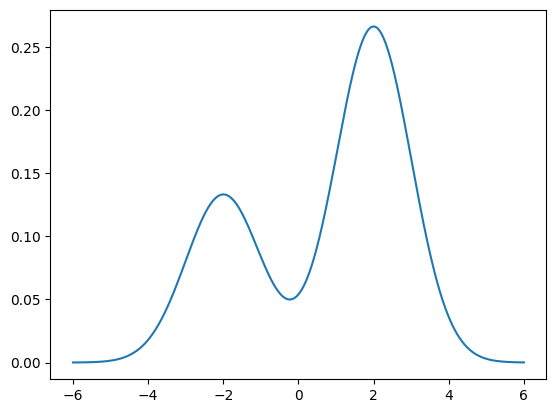

In [126]:
fig = plt.figure()
ax = fig.subplots()
x = jnp.linspace(-6, 6, 10000)
sns.lineplot(y=vmap(gaussian_mixture)(x), x=x, ax=ax);

In [127]:
num_particles = 100

# Sample initial particles from a (-10, 1) normal distribution
initial_particles = (-10) + jax.random.normal(
        jax.random.PRNGKey(3),
        shape=(num_particles,)
        )

<Axes: ylabel='Density'>

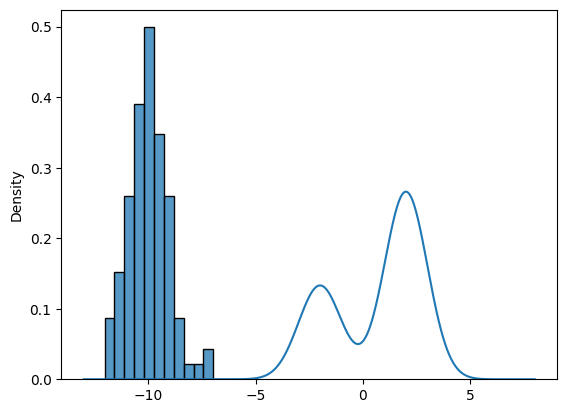

In [128]:
fig = plt.figure()
ax = fig.subplots()
x = jnp.linspace(-13, 8, 10000)
sns.histplot(initial_particles, ax=ax, stat="density")
sns.lineplot(y=vmap(gaussian_mixture)(x), x=x, ax=ax)

In [129]:
# Run the algorithm
out = svgd_training_loop(
    initial_position = initial_particles,
    initial_kernel_parameters=median_heuristic({"length_scale": 1}, initial_particles),
    log_p = gaussian_mixture_log_pdf,
    kernel=rbf_kernel,
    optimizer=optax.adam(0.3),
    #optimizer=optax.GradientTransformation(initial_particles,0.3),
    num_iterations=500,
    #progress=True
    )

Below we can now see that particles are being pushed towards the desired distribution

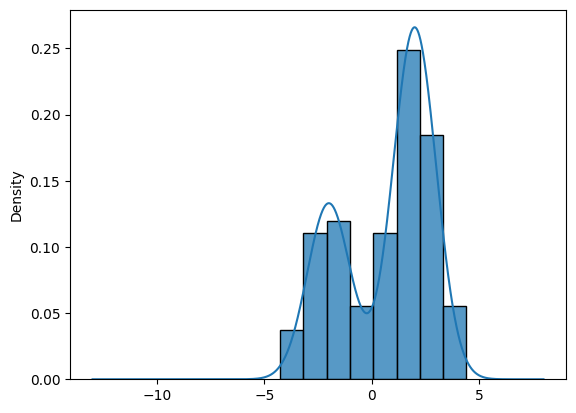

In [130]:
# Plot the results
def plot(particles):
    fig = plt.figure()
    ax = fig.subplots()
    x = jnp.linspace(-13, 8, 10000)
    sns.histplot(particles, ax=ax, stat="density")
    #sns.histplot(initial_particles, ax=ax, stat="density")
    sns.lineplot(y=vmap(gaussian_mixture)(x), x=x, ax=ax)
    #plt.xlim([-13, 8]);
    # plt.show()
plot(out.particles)

Estimated expectation is close to True expectation

In [131]:
print(f"Estimated expectation: {out.particles.mean()}")
print(f"True expectation: {2/3}")

Estimated expectation: 0.6175753117870498
True expectation: 0.6666666666666666
